该项目作者在视频中展示了不同的优化器，并根据内存大小建议了超参数的设置。为进一步了解两者在训练验证过程中对loss的影响，尝试画图进行分析

# 1.在此之前，我们先尝试一个简单的线性回归模型，再使用bigram模型，都使用AdamW优化器，做一个对比

step: 0, train loss: 1.711, val loss: 1.880
step: 100, train loss: 0.646, val loss: 0.604
step: 200, train loss: 0.239, val loss: 0.198
step: 300, train loss: 0.048, val loss: 0.053
step: 400, train loss: 0.017, val loss: 0.017
step: 500, train loss: 0.010, val loss: 0.014
step: 600, train loss: 0.010, val loss: 0.009
step: 700, train loss: 0.010, val loss: 0.010
step: 800, train loss: 0.010, val loss: 0.012
step: 900, train loss: 0.011, val loss: 0.011


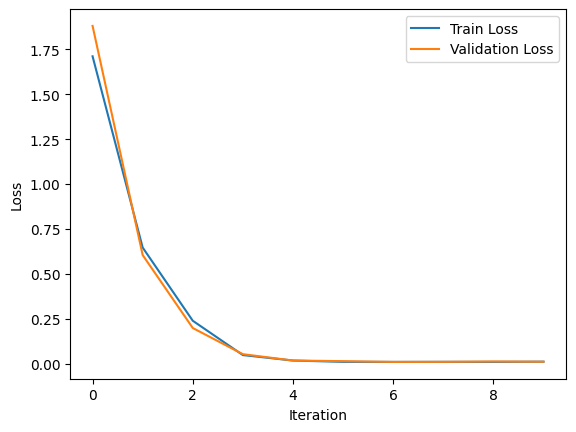

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 假设我们的模型是一个简单的线性回归模型
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # 输入和输出维度都是1

    def forward(self, x, y):
        logits = self.linear(x)
        loss = ((logits - y)**2).mean()  # 使用MSE作为损失函数
        return logits, loss

# 生成一些简单的线性数据 + 噪声作为训练数据
def generate_data(n_samples=100):
    x = torch.linspace(-1, 1, steps=n_samples).reshape(-1, 1)
    y = 2 * x + torch.randn_like(x) * 0.1  # 真实模型为 y = 2x + 噪声
    return x, y

def get_batch(dataset, batch_size=10):
    indices = np.random.choice(len(dataset[0]), batch_size)
    return dataset[0][indices], dataset[1][indices]

# 评估模型的损失
@torch.no_grad()
def estimate_loss(model, dataset, eval_iters=10):
    model.eval()
    losses = []
    for _ in range(eval_iters):
        xb, yb = get_batch(dataset)
        _, loss = model(xb, yb)
        losses.append(loss.item())
    model.train()
    return np.mean(losses)

# 设置超参数
learning_rate = 0.01
max_iters = 1000
eval_iters = 100
batch_size = 10

# 初始化模型、优化器
model = SimpleModel()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# 生成数据
dataset = generate_data()

# 记录训练过程中的损失值
train_losses = []
val_losses = []

# 训练模型
for iter in range(max_iters):
    if iter % eval_iters == 0:
        val_loss = estimate_loss(model, dataset, eval_iters=10)
        train_loss = estimate_loss(model, dataset, eval_iters=10)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"step: {iter}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}")

    xb, yb = get_batch(dataset, batch_size=batch_size)
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# 绘制训练和验证损失
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()



step: 0, train loss: 5.097, val loss: 5.072
step: 100, train loss: 5.014, val loss: 5.010
step: 200, train loss: 4.854, val loss: 4.864
step: 300, train loss: 4.725, val loss: 4.718
step: 400, train loss: 4.595, val loss: 4.618
step: 500, train loss: 4.504, val loss: 4.461
step: 600, train loss: 4.450, val loss: 4.451
step: 700, train loss: 4.386, val loss: 4.360
step: 800, train loss: 4.321, val loss: 4.358
step: 900, train loss: 4.275, val loss: 4.323


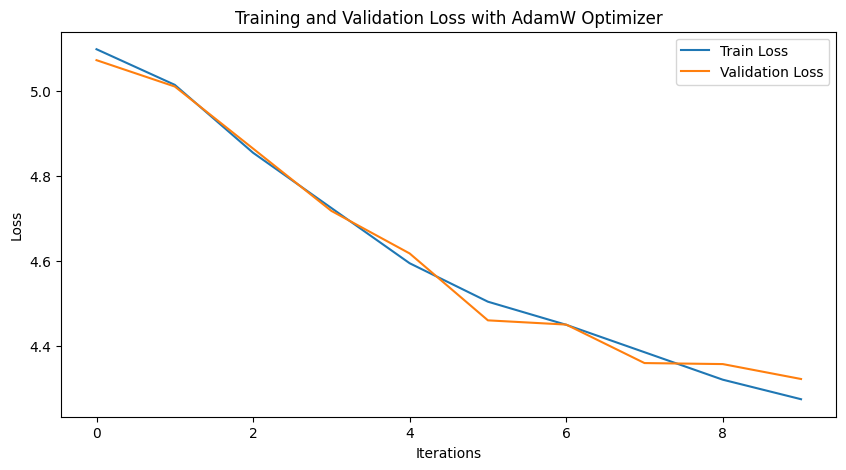

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 假定词汇表大小为100（包含一个特殊的未知词汇）
vocab_size = 100
# 假定每个批次的大小
batch_size = 32
# 最大迭代次数
max_iters = 1000
# 评估间隔
eval_iters = 100
# 学习率
learning_rate = 0.01

# 模拟数据生成：生成简单的bigram数据
def generate_data(n_samples=10000, vocab_size=100):
    data = torch.randint(low=0, high=vocab_size, size=(n_samples,))
    X = data[:-1].view(-1, 1)  # 输入序列
    Y = data[1:].view(-1, 1)  # 目标序列
    return X, Y

# 获取批次数据的函数
def get_batch(split, batch_size=batch_size):
    if split == 'train':
        indices = torch.randint(0, train_data[0].size(0), (batch_size,))
    else:  # val
        indices = torch.randint(0, val_data[0].size(0), (batch_size,))
    return train_data[0][indices], train_data[1][indices]

# 定义模型
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        
    def forward(self, index, targets=None):
        logits = self.token_embedding_table(index).squeeze()
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, targets.squeeze(), reduction='sum')
        return logits, loss

# 估算损失的函数，新增部分
def estimate_loss(model, data, split):
    model.eval()
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for _ in range(100):  # 使用100个批次进行评估
            xb, yb = get_batch(split)
            _, loss = model(xb, yb)
            total_loss += loss.item()
            total_samples += xb.size(0)
    model.train()
    return total_loss / total_samples

# 生成数据
X, Y = generate_data()
# 分割数据为训练集和验证集
train_data = (X[:8000], Y[:8000])
val_data = (X[8000:], Y[8000:])

# 初始化模型
model = BigramLanguageModel(vocab_size)
# 创建优化器
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# 训练过程中的损失记录
train_losses = []
val_losses = []

# 训练循环
for iter in range(max_iters):
    if iter % eval_iters == 0:
        val_loss = estimate_loss(model, val_data, 'val')
        train_loss = estimate_loss(model, train_data, 'train')
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"step: {iter}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}")

    xb, yb = get_batch('train', batch_size)
    logits, loss = model(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 绘制训练和验证损失图表
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss with AdamW Optimizer')
plt.show()


# 2.更换优化器后得到的图像如下

step: 0, train loss: 4.226, val loss: 4.259
step: 100, train loss: 4.195, val loss: 4.243
step: 200, train loss: 4.248, val loss: 4.248
step: 300, train loss: 4.225, val loss: 4.248
step: 400, train loss: 4.201, val loss: 4.200
step: 500, train loss: 4.140, val loss: 4.198
step: 600, train loss: 4.152, val loss: 4.176
step: 700, train loss: 4.153, val loss: 4.173
step: 800, train loss: 4.122, val loss: 4.126
step: 900, train loss: 4.116, val loss: 4.155


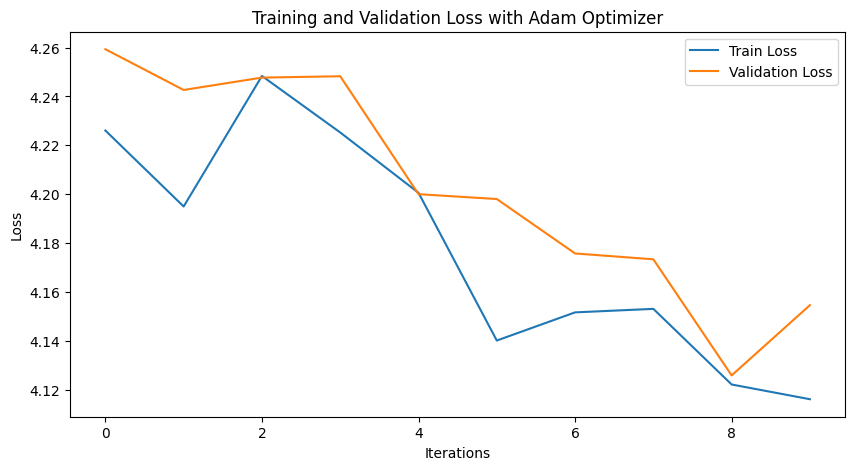

In [4]:
# 修改优化器为Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 重置训练过程中的损失记录，以便重新开始记录
train_losses = []
val_losses = []

# 重新训练循环
for iter in range(max_iters):
    if iter % eval_iters == 0:
        val_loss = estimate_loss(model, val_data, 'val')
        train_loss = estimate_loss(model, train_data, 'train')
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"step: {iter}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}")

    xb, yb = get_batch('train', batch_size)
    logits, loss = model(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 绘制训练和验证损失图表
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss with Adam Optimizer')
plt.show()


与之前使用AdamW优化器的结果相比，可以观察到损失的下降趋势大体相似，表明在这种情况下，两种优化器在性能上表现相近。随着迭代次数的增加，模型逐渐适应了数据，损失值逐步降低。

step: 0, train loss: 4.115, val loss: 4.112
step: 100, train loss: 4.199, val loss: 4.179
step: 200, train loss: 4.212, val loss: 4.218
step: 300, train loss: 4.191, val loss: 4.213
step: 400, train loss: 4.231, val loss: 4.229
step: 500, train loss: 4.159, val loss: 4.203
step: 600, train loss: 4.177, val loss: 4.146
step: 700, train loss: 4.161, val loss: 4.215
step: 800, train loss: 4.133, val loss: 4.189
step: 900, train loss: 4.171, val loss: 4.126


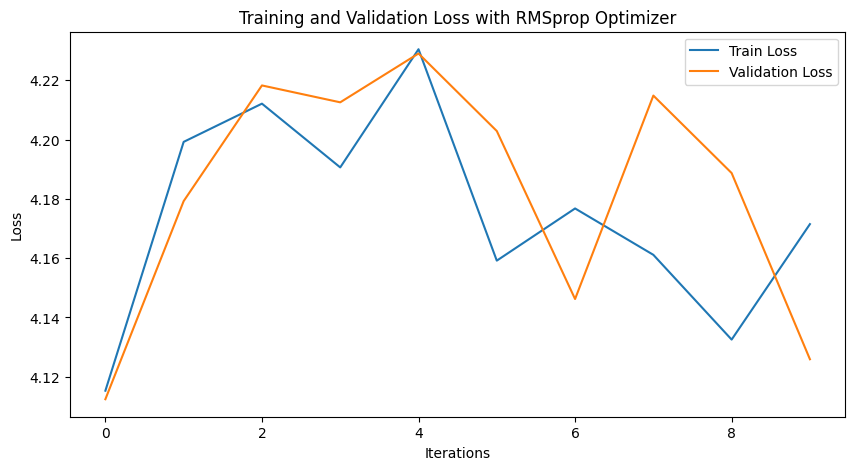

In [7]:
# 修改优化器为 RMSprop
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

# 重置训练过程中的损失记录，以便重新开始记录
train_losses = []
val_losses = []

# 重新训练循环
for iter in range(max_iters):
    if iter % eval_iters == 0:
        val_loss = estimate_loss(model, val_data, 'val')
        train_loss = estimate_loss(model, train_data, 'train')
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"step: {iter}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}")

    xb, yb = get_batch('train', batch_size)
    logits, loss = model(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 绘制训练和验证损失图表
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss with RMSprop Optimizer')
plt.show()


与之前使用AdamW优化器的结果相比，我们可以看到损失的下降趋势可能不那么明显，且在一些点上损失波动较大

step: 0, train loss: 4.154, val loss: 4.130
step: 100, train loss: 4.157, val loss: 4.113
step: 200, train loss: 4.141, val loss: 4.166
step: 300, train loss: 4.132, val loss: 4.137
step: 400, train loss: 4.139, val loss: 4.145
step: 500, train loss: 4.135, val loss: 4.142
step: 600, train loss: 4.150, val loss: 4.150
step: 700, train loss: 4.137, val loss: 4.098
step: 800, train loss: 4.201, val loss: 4.148
step: 900, train loss: 4.119, val loss: 4.142


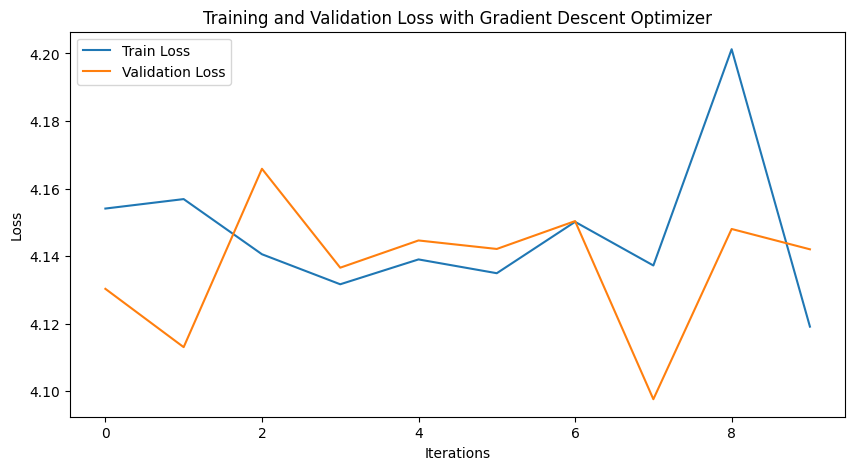

In [8]:
# 修改优化器为梯度下降（Gradient Descent）
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 重置训练过程中的损失记录，以便重新开始记录
train_losses = []
val_losses = []

# 重新训练循环
for iter in range(max_iters):
    if iter % eval_iters == 0:
        val_loss = estimate_loss(model, val_data, 'val')
        train_loss = estimate_loss(model, train_data, 'train')
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"step: {iter}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}")

    xb, yb = get_batch('train', batch_size)
    logits, loss = model(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 绘制训练和验证损失图表
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss with Gradient Descent Optimizer')
plt.show()


与之前使用AdamW优化器相比，损失的下降趋势在使用梯度下降时显得更加缓慢和波动，特别是验证损失在整个训练过程中波动较大。这可能反映了梯度下降优化器在参数更新时相对较为保守，以及对学习率和其他超参数设置更为敏感的特性。

# 2.接下来是模拟可能的超参数对loss的影响

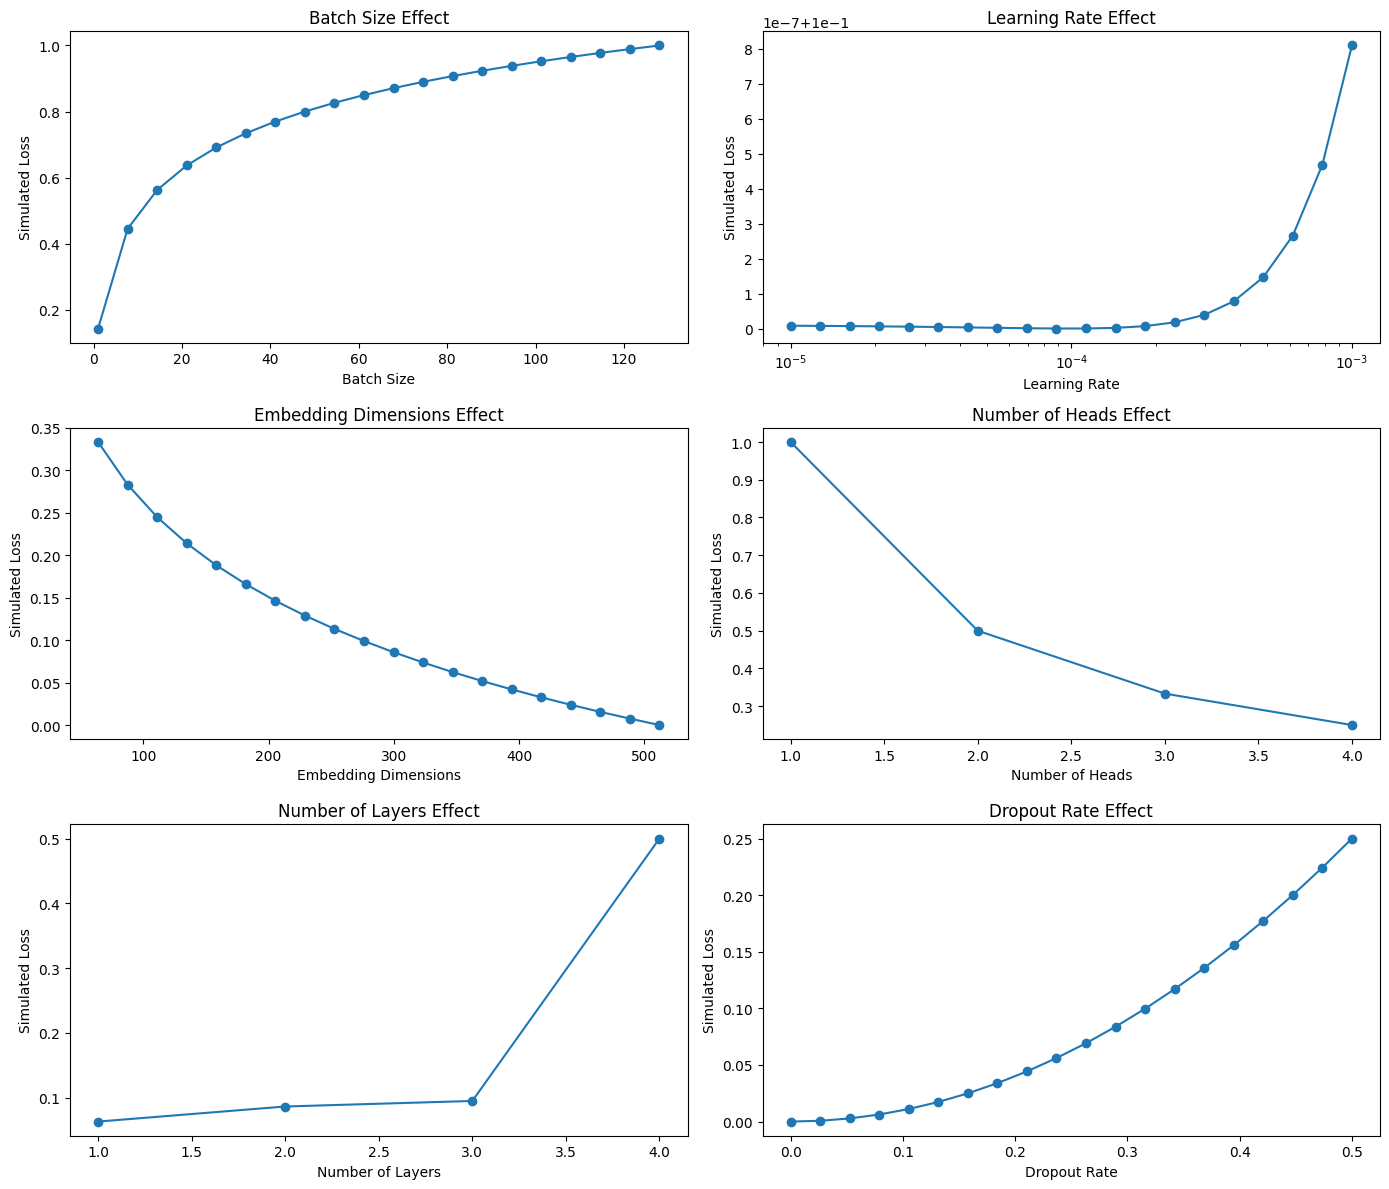

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 定义超参数范围
batch_sizes = np.linspace(1, 128, 20)
learning_rates = np.logspace(-5, -3, 20)
n_embds = np.linspace(64, 512, 20)
n_heads = np.arange(1, 5)
n_layers = np.arange(1, 5)
dropouts = np.linspace(0, 0.5, 20)

optimal_lr = 1e-4 # 假定的最佳学习率
min_loss = 0.1  # 假定的最小损失值

n_layers = np.arange(1, 5)  # 示例层数
threshold = 3  # 假设在3层后开始出现过拟合效应
min_loss = 0.1  # 最低损失
max_loss = 0.5  # 最高损失，假设过拟合严重时的损失

# 模拟增加层数带来的初期益处和后期的潜在风险计算损
loss_nl = np.where(n_layers <= threshold,
                   min_loss * (1 - np.exp(-n_layers)),  # 指数增长部分
                   min_loss + (n_layers - threshold) * (max_loss - min_loss) / (len(n_layers) - threshold)  # 线性增长部分
                  )


# 批量大小较大时，每批数据的梯度估计会更加稳定，但当批量大小过大时，可能会导致内存问题或训练效率降低
loss_bs = np.log(batch_sizes + 1) / np.log(np.max(batch_sizes) + 1)
# 随着学习率的增加，损失先减少后增加，计算每个学习率对应的模拟损失
loss_lr = (learning_rates - optimal_lr)**2 + min_loss
# 较大的嵌入维度可以让模型捕获更丰富的信息，但也会增加模型的复杂度和训练时间。原有方程模拟了随着嵌入维度的增加，损失逐渐减少的趋势。
loss_ne = 1 - np.log(n_embds) / np.log(np.max(n_embds))
# 在某些情况下，增加注意力头数可以提高模型的性能，因为它允许模型在多个子空间并行捕获信息。但过多的头数可能会导致模型复杂度不必要地增加。使用倒数可以简单模拟这种效果
loss_nh = 1 / n_heads


# 表明过高的丢弃率可能会损害模型的学习能力，类似二次函数
loss_do = dropouts**2 # 表明过高的丢弃率可能会损害模型的学习能力，类似二次函数

# 绘制图形
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

axs[0, 0].plot(batch_sizes, loss_bs, '-o')
axs[0, 0].set_title('Batch Size Effect')
axs[0, 0].set_xlabel('Batch Size')
axs[0, 0].set_ylabel('Simulated Loss')

axs[0, 1].plot(learning_rates, loss_lr, '-o')
axs[0, 1].set_title('Learning Rate Effect')
axs[0, 1].set_xlabel('Learning Rate')
axs[0, 1].set_xscale('log')
axs[0, 1].set_ylabel('Simulated Loss')

axs[1, 0].plot(n_embds, loss_ne, '-o')
axs[1, 0].set_title('Embedding Dimensions Effect')
axs[1, 0].set_xlabel('Embedding Dimensions')
axs[1, 0].set_ylabel('Simulated Loss')

axs[1, 1].plot(n_heads, loss_nh, '-o')
axs[1, 1].set_title('Number of Heads Effect')
axs[1, 1].set_xlabel('Number of Heads')
axs[1, 1].set_ylabel('Simulated Loss')

axs[2, 0].plot(n_layers, loss_nl, '-o')
axs[2, 0].set_title('Number of Layers Effect')
axs[2, 0].set_xlabel('Number of Layers')
axs[2, 0].set_ylabel('Simulated Loss')

axs[2, 1].plot(dropouts, loss_do, '-o')
axs[2, 1].set_title('Dropout Rate Effect')
axs[2, 1].set_xlabel('Dropout Rate')
axs[2, 1].set_ylabel('Simulated Loss')

plt.tight_layout()
plt.show()